# 📊 Z-Score Outlier Analysis

## 🎯 Objective
Analyze outliers in `actual_delivery_days` using the **Z-Score Method**.

Instead of a hard threshold (e.g., < 60 days), we will:
1.  Calculate Z-scores: $Z = \frac{x - \mu}{\sigma}$
2.  Identify data points with $|Z| > 3$ (statistically significant outliers).
3.  Visualize the distribution and impact of these outliers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")

# Load processed data (before the <60 filter if possible, otherwise we analyze the processed one)
# Ideally, we would reload the master merging steps, but let's check the current distribution first.
df = pd.read_csv("olist_processed.csv")

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (109305, 15)


,order_id,product_id,seller_id,price,freight_value,product_weight_g,product_volume_cm3,distance_km,is_same_state,purchase_year,purchase_month,purchase_weekday,estimated_delivery_days,actual_delivery_days,order_purchase_timestamp
0,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1000.0,4096.0,566.040211,0,2016,9,3,18.488449,54.813194,2016-09-15 12:16:38
1,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1000.0,4096.0,566.040211,0,2016,9,3,18.488449,54.813194,2016-09-15 12:16:38
2,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1000.0,4096.0,566.040211,0,2016,9,3,18.488449,54.813194,2016-09-15 12:16:38
3,3b697a20d9e427646d92567910af6d57,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,29.90,15.56,300.0,4096.0,708.535291,0,2016,10,0,23.593866,23.178738,2016-10-03 09:44:50
4,be5bc2f0da14d8071e2d45451ad119d9,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,21.90,17.19,400.0,4096.0,915.734331,0,2016,10,0,34.293866,24.057500,2016-10-03 16:56:50


## 1. Calculate Z-Scores
We verify how many standard deviations away each delivery time is from the mean.

In [2]:
target = 'actual_delivery_days'

# Basic Stats
mu = df[target].mean()
sigma = df[target].std()
print(f"Mean Delivery: {mu:.2f} days")
print(f"Std Dev:       {sigma:.2f} days")

# Calculate Z-Score
df['z_score'] = (df[target] - mu) / sigma

# Count Outliers (|Z| > 3)
threshold = 3
outliers = df[np.abs(df['z_score']) > threshold]

print(f"\nOutliers detected (Z > {threshold}): {len(outliers)}")
print(f"Percentage: {(len(outliers) / len(df) * 100):.2f}%")

outliers.sort_values(target, ascending=False).head(10)[['order_id', target, 'z_score']]

Mean Delivery: 12.24 days
Std Dev:       8.31 days

Outliers detected (Z > 3): 2124
Percentage: 1.94%


,order_id,actual_delivery_days,z_score
40697,fcf77320278b491829c6e5d767a3f20d,59.998021,5.748206
41157,08904f6557108c451821501ca9e6aa4a,59.968079,5.744602
59622,3c901df8e80c646961877910379f4c1d,59.931701,5.740224
25211,cf5bae440125a8f7eccfde72d25e1913,59.872720,5.733125
41324,f79166d484b12d995cc47ff0fd43db75,59.820046,5.726785
61598,a7b6379e7ca83fc534678ad86108cff7,59.806771,5.725188
5310,b02983703060845dbc7fe979ceaf2c3b,59.660405,5.707571
2100,194a9f43598155086b091e0c827ad480,59.556458,5.695060
71006,d788474677e79e148bb5cf2c5f0f637a,59.478275,5.685650
71005,d788474677e79e148bb5cf2c5f0f637a,59.478275,5.685650


## 2. Visualize Outliers
Plot the distribution showing the Z-score threshold boundaries.

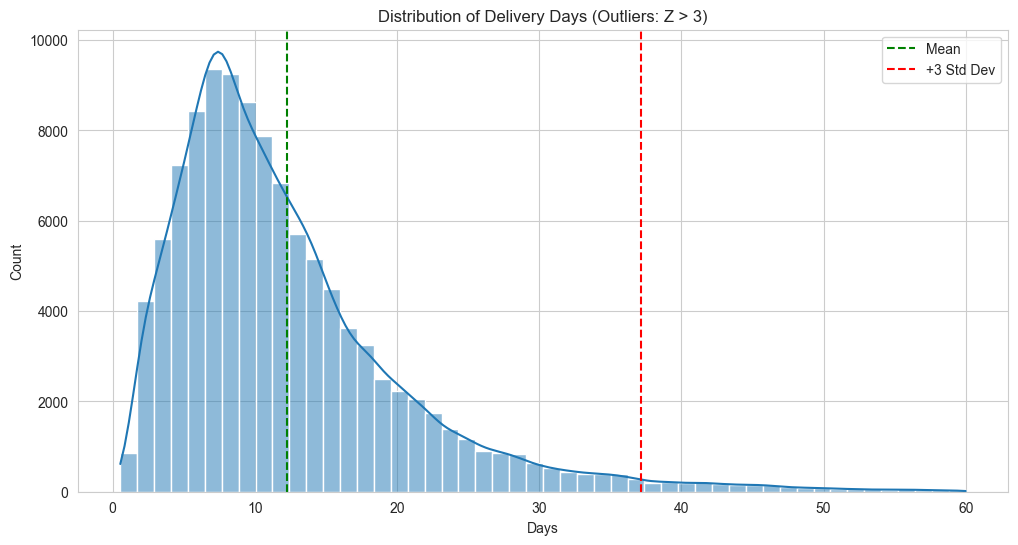

In [3]:
plt.figure(figsize=(12, 6))
sns.histplot(df[target], bins=50, kde=True)

# Add lines for mean and std devs
plt.axvline(mu, color='green', linestyle='--', label='Mean')
plt.axvline(mu + 3*sigma, color='red', linestyle='--', label='+3 Std Dev')

plt.title(f'Distribution of Delivery Days (Outliers: Z > 3)')
plt.xlabel('Days')
plt.legend()
plt.show()

## 3. Impact Analysis
Let's see if these outliers have specific characteristics (e.g., long distances).

Avg Distance (Normal):   585.13 km
Avg Distance (Outliers): 1087.63 km


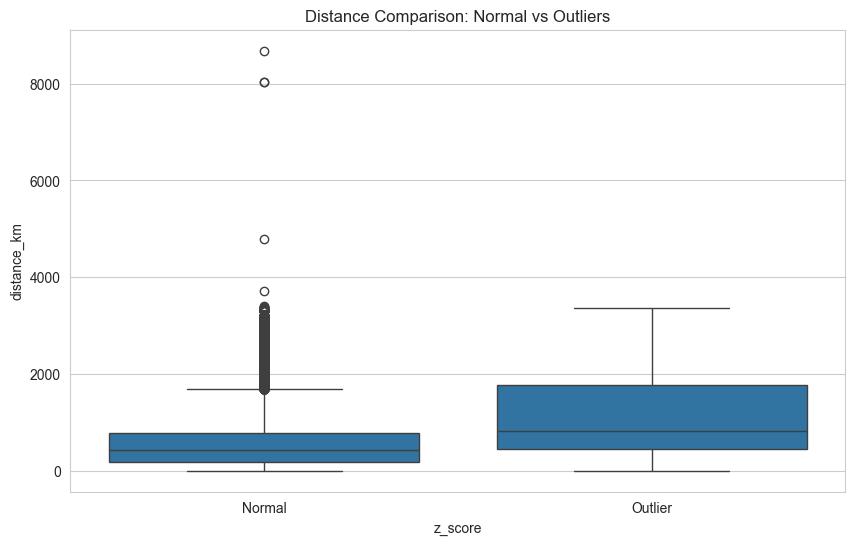

In [4]:
# Compare Distances of Outliers vs Normal
normal_data = df[np.abs(df['z_score']) <= 3]

print(f"Avg Distance (Normal):   {normal_data['distance_km'].mean():.2f} km")
print(f"Avg Distance (Outliers): {outliers['distance_km'].mean():.2f} km")

plt.figure(figsize=(10, 6))
sns.boxplot(x=np.abs(df['z_score']) > 3, y='distance_km', data=df)
plt.xticks([0, 1], ['Normal', 'Outlier'])
plt.title("Distance Comparison: Normal vs Outliers")
plt.show()